<a href="https://colab.research.google.com/github/rdkdaniel/Computer-Vision/blob/main/Cancer_Detection_(CTCs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Key links: https://towardsdatascience.com/convolutional-neural-network-for-breast-cancer-classification-52f1213dcc9

https://python.plainenglish.io/skin-cancer-detection-using-convolutional-neural-networks-38f386cdc6d7

# **1. Skin Cancer**

**Libraries**

In [22]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

**The Data**

In [23]:
#https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic?resource=download

In [24]:
#Connecting colab with kaggle to get the data
#Install the Kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Make a directory named “.kaggle”
! mkdir ~/.kaggle

In [ ]:
#Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

In [ ]:
#Allocate the required permission for this file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Downloading dataset
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

 99% 779M/786M [00:05<00:00, 136MB/s]
100% 786M/786M [00:05<00:00, 139MB/s]


**Unzipping the dataset**

In [ ]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

After unzipping the dowloaded dataset, the entire dataset, (now as a folder) were available on the Colab File section on the left.

Expanding the folder holding this dataset, would reveal the two splits i.e. Train and Test folder.

It is these subsequent folders that now are specified in the next section of code

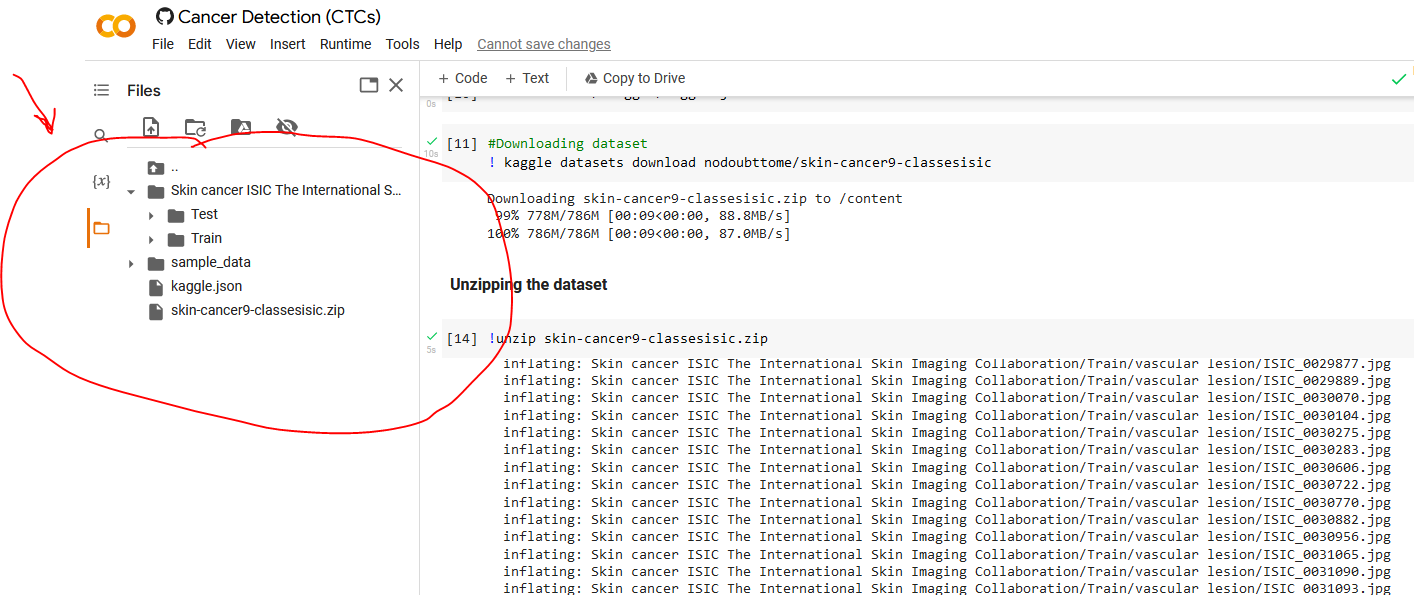

**Define path for train and test images**

In [25]:
train_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
test_path="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [26]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# **Data Preparation**

In [27]:
batch_size = 32
img_height = 180
img_width = 180

**Train Data Set Creation** 

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


**Validation Data Set Creation**

In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [30]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# **Visualizing the data**

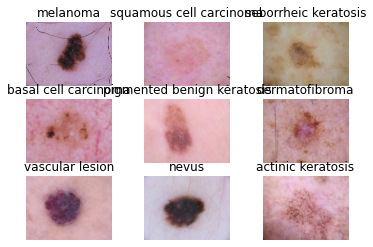

In [ ]:
import matplotlib.pyplot as plt
num=0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The image_batch is a tensor of the shape (32, 180, 180, 3). 

This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **The Models**

# **Model 1**

**1.0 Creating model 1**

In [ ]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

**1.1 Compiling the model**

In [ ]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**1.2 Training the model**

In [ ]:
epochs = 10 #initially was 20, trying 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 62s 1s/step - loss: 3.0634 - accuracy: 0.2026 - val_loss: 1.9500 - val_accuracy: 0.3043
Epoch 2/10
56/56 [==============================] - 59s 1s/step - loss: 1.9119 - accuracy: 0.2729 - val_loss: 1.8208 - val_accuracy: 0.3289
Epoch 3/10
56/56 [==============================] - 59s 1s/step - loss: 1.7502 - accuracy: 0.3811 - val_loss: 1.6007 - val_accuracy: 0.4720
Epoch 4/10
56/56 [==============================] - 58s 1s/step - loss: 1.6083 - accuracy: 0.4347 - val_loss: 1.5044 - val_accuracy: 0.5280
Epoch 5/10
56/56 [==============================] - 59s 1s/step - loss: 1.4931 - accuracy: 0.4888 - val_loss: 1.5103 - val_accuracy: 0.4877
Epoch 6/10
56/56 [==============================] - 59s 1s/step - loss: 1.3501 - accuracy: 0.5240 - val_loss: 1.4674 - val_accuracy: 0.4989
Epoch 7/10
56/56 [==============================] - 59s 1s/step - loss: 1.3397 - accuracy: 0.5352 - val_loss: 1.4225 - val_accuracy: 0.5101
Epoch 8/10
56/56 [==

In [ ]:
#summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

**1.3 Visualizing training results** 

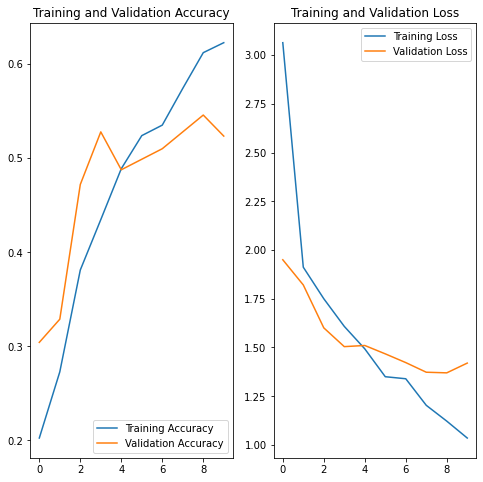

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1.4 Observations

The accuracy of the model for the Training data set is at 78%. But the Validation accuracy is not in par with the training accuracy.
It is only at 53%. The validation loss as observed is very high.
This could also be indicative of some Overfit in the model.
We could add some Dropout layers and remove the BatchNormalization layers. And by adding a few more layers, we could improve the accuracy by trying to extract more features.



# **20 epochs**

In [ ]:
epochs = 20 #initially was 20, trying 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 133s 2s/step - loss: 3.0183 - accuracy: 0.1948 - val_loss: 2.0950 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 98s 2s/step - loss: 1.8743 - accuracy: 0.3259 - val_loss: 1.8804 - val_accuracy: 0.3893
Epoch 3/20
56/56 [==============================] - 97s 2s/step - loss: 1.6156 - accuracy: 0.4414 - val_loss: 1.7665 - val_accuracy: 0.4094
Epoch 4/20
56/56 [==============================] - 93s 2s/step - loss: 1.4974 - accuracy: 0.4939 - val_loss: 1.5028 - val_accuracy: 0.5011
Epoch 5/20
56/56 [==============================] - 93s 2s/step - loss: 1.4412 - accuracy: 0.4955 - val_loss: 1.5547 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 92s 2s/step - loss: 1.3349 - accuracy: 0.5374 - val_loss: 1.4434 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 93s 2s/step - loss: 1.2428 - accuracy: 0.5720 - val_loss: 1.4353 - val_accuracy: 0.5302
Epoch 8/20
56/56 [=

In [ ]:
#summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

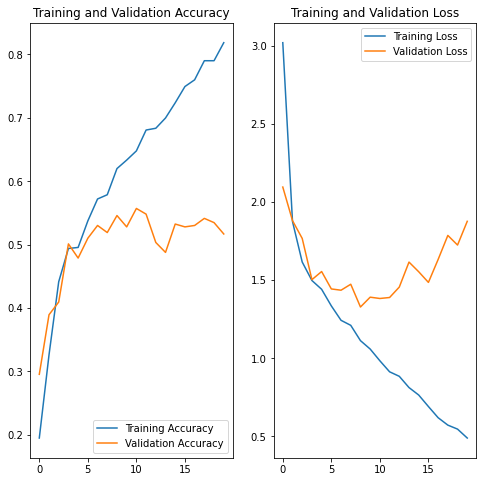

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**20 epochs is showing a rising validation loss after 8 epochs.**

**Our training loss is falling but validation is rising which points towards overfitting.**

**Thus, next epoochs will be 8 instead of 30.**

# **8 Epochs**

In [ ]:
epochs = 8
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/8
56/56 [==============================] - 112s 2s/step - loss: 0.4772 - accuracy: 0.8198 - val_loss: 1.6570 - val_accuracy: 0.5324
Epoch 2/8
56/56 [==============================] - 107s 2s/step - loss: 0.4081 - accuracy: 0.8465 - val_loss: 1.8829 - val_accuracy: 0.5459
Epoch 3/8
56/56 [==============================] - 107s 2s/step - loss: 0.4386 - accuracy: 0.8343 - val_loss: 2.0782 - val_accuracy: 0.5056
Epoch 4/8
56/56 [==============================] - 108s 2s/step - loss: 0.4026 - accuracy: 0.8426 - val_loss: 2.0498 - val_accuracy: 0.5190
Epoch 5/8
56/56 [==============================] - 108s 2s/step - loss: 0.3789 - accuracy: 0.8532 - val_loss: 2.0182 - val_accuracy: 0.5324
Epoch 6/8
56/56 [==============================] - 113s 2s/step - loss: 0.3423 - accuracy: 0.8666 - val_loss: 1.9783 - val_accuracy: 0.5213
Epoch 7/8
56/56 [==============================] - 110s 2s/step - loss: 0.3054 - accuracy: 0.8778 - val_loss: 2.1216 - val_accuracy: 0.5391
Epoch 8/8
56/56 [===

In [ ]:
#summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

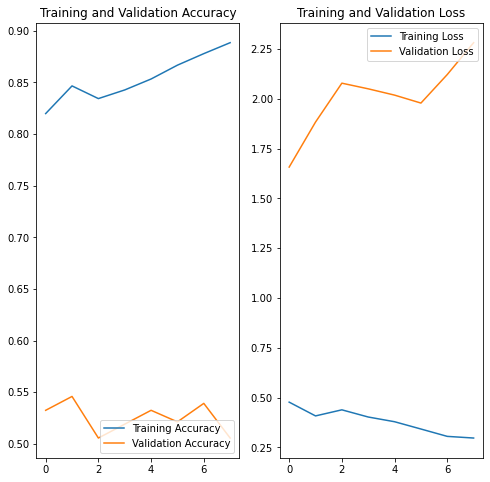

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Hmm, this is weird.**

**8 epochs are worse. Think 10 is the best we can do.**

**Other model (2) is better.**

# **Model 2**

**2.0 Creating the Model**

In [ ]:
model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

**2.1 Compiling the model**

In [ ]:
model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**2.2 Training the model**

In [ ]:
epochs = 10 #what of 10 epochs
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 238s 4s/step - loss: 2.1439 - accuracy: 0.1931 - val_loss: 2.0486 - val_accuracy: 0.2058
Epoch 2/10
56/56 [==============================] - 234s 4s/step - loss: 2.0375 - accuracy: 0.2026 - val_loss: 2.0296 - val_accuracy: 0.1924
Epoch 3/10
56/56 [==============================] - 234s 4s/step - loss: 2.0341 - accuracy: 0.2121 - val_loss: 2.0237 - val_accuracy: 0.1924
Epoch 4/10
56/56 [==============================] - 235s 4s/step - loss: 2.0294 - accuracy: 0.1942 - val_loss: 2.0244 - val_accuracy: 0.1924
Epoch 5/10
56/56 [==============================] - 234s 4s/step - loss: 2.0216 - accuracy: 0.2037 - val_loss: 2.0236 - val_accuracy: 0.2058
Epoch 6/10
56/56 [==============================] - 234s 4s/step - loss: 2.0242 - accuracy: 0.2081 - val_loss: 2.0178 - val_accuracy: 0.1924
Epoch 7/10
56/56 [==============================] - 234s 4s/step - loss: 2.0189 - accuracy: 0.2009 - val_loss: 2.0236 - val_accuracy: 0.1924
Epoch 8/10
56

**2.3 Visualizing the results** 

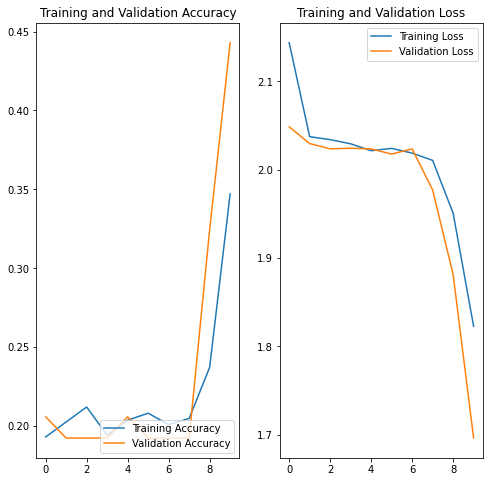

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**2.4 Observations** 

In [ ]:
#The model accuracy for Train data set has dropped to nearly 45%.
#The accuracy for the Validation set is at 40%.
#This is a much better model compared to the previous model as there seems to be No Overfit with the training accuracy 45% and validation accuracy at 40%.

# **What of 12 Epochs**

In [ ]:
epochs = 12
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
56/56 [==============================] - 386s 7s/step - loss: 2.1205 - accuracy: 0.1786 - val_loss: 2.0546 - val_accuracy: 0.2058
Epoch 2/12
56/56 [==============================] - 395s 7s/step - loss: 2.0194 - accuracy: 0.2087 - val_loss: 1.9611 - val_accuracy: 0.2774
Epoch 3/12
56/56 [==============================] - 367s 7s/step - loss: 1.8876 - accuracy: 0.2952 - val_loss: 2.0331 - val_accuracy: 0.2371
Epoch 4/12
56/56 [==============================] - 358s 6s/step - loss: 1.8209 - accuracy: 0.3142 - val_loss: 1.6339 - val_accuracy: 0.4049
Epoch 5/12
56/56 [==============================] - 361s 6s/step - loss: 1.7178 - accuracy: 0.3795 - val_loss: 1.5997 - val_accuracy: 0.3915
Epoch 6/12
56/56 [==============================] - 381s 7s/step - loss: 1.6479 - accuracy: 0.3940 - val_loss: 1.5925 - val_accuracy: 0.4116
Epoch 7/12
56/56 [==============================] - 485s 9s/step - loss: 1.6399 - accuracy: 0.3912 - val_loss: 1.7110 - val_accuracy: 0.3602
Epoch 8/12
56

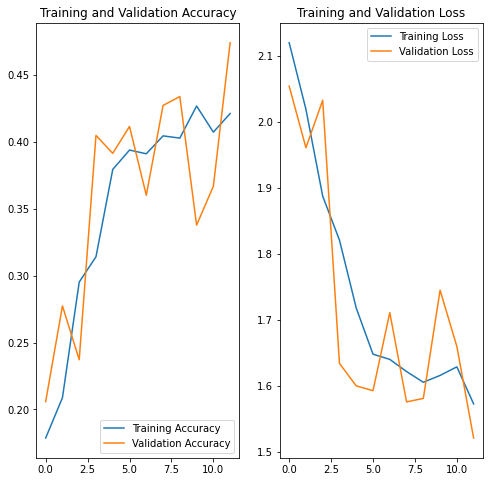

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**This is beautiful!!!**:)

**This performance is even better than the one below.**

**That is, after augmenting data -  no need for it**.

**But, we can improve the perfoamnce - maybe - by augmenting and using the same magic epoch number (12).**

# **Augment Data - Trying to get better results**

In [31]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

**Visualizing the Augmented Data**

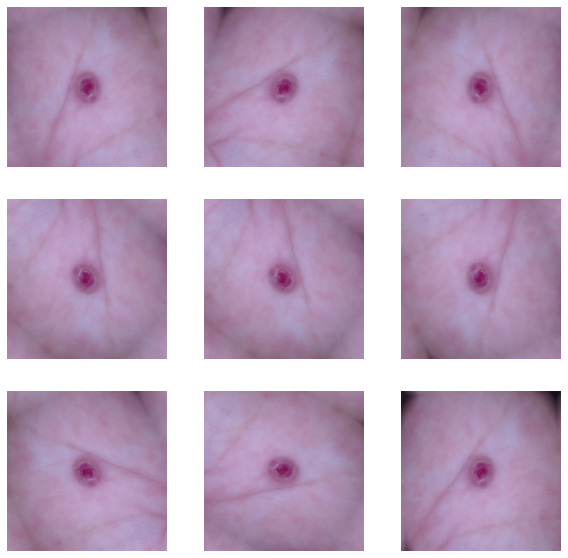

In [32]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

**Model 2**

Creating the Model

In [33]:
model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

**Compiling the model**

In [34]:
model_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**Training the model** 

In [ ]:
epochs = 20 #Let us use 10 epochs but will use 20 later
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
56/56 [==============================] - 359s 6s/step - loss: 2.1122 - accuracy: 0.1691 - val_loss: 2.0466 - val_accuracy: 0.2058
Epoch 2/10
56/56 [==============================] - 347s 6s/step - loss: 2.0454 - accuracy: 0.1987 - val_loss: 2.0329 - val_accuracy: 0.2058
Epoch 3/10
56/56 [==============================] - 348s 6s/step - loss: 2.0368 - accuracy: 0.1925 - val_loss: 2.0367 - val_accuracy: 0.2058
Epoch 4/10
56/56 [==============================] - 347s 6s/step - loss: 2.0341 - accuracy: 0.1825 - val_loss: 2.0385 - val_accuracy: 0.2058
Epoch 5/10
56/56 [==============================] - 348s 6s/step - loss: 2.0337 - accuracy: 0.2003 - val_loss: 2.0389 - val_accuracy: 0.2058
Epoch 6/10
56/56 [==============================] - 347s 6s/step - loss: 2.0309 - accuracy: 0.1864 - val_loss: 2.0289 - val_accuracy: 0.2058
Epoch 7/10
56/56 [==============================] - 346s 6s/step - loss: 2.0206 - accuracy: 0.2093 - val_loss: 2.0151 - val_accuracy: 0.2058
Epoch 8/10
56

**Visualizing the results** 

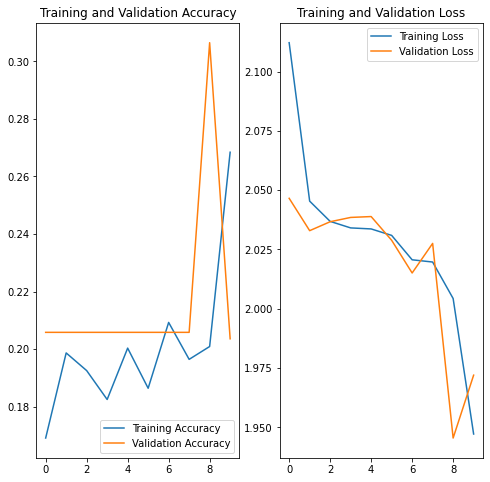

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can try augmenting the data again.
Adding epochs to 20 and 30. Then compare results.

However, remember too many epochs will affect validation accuracy (increasing validaton loss). But the training accurcay will increase (decrease in training loss). This will ultimatly lead to overfitting.

link: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/

Getting the optimal epochs?

https://gretel.ai/gretel-synthetics-faqs/how-many-epochs-should-i-train-my-model-with - recommends a rule of thumb where epochs are determined by the complexity of dataset (mention of perplexity).
Epochs then become 3 times the number of columns in a dataset.

https://www.researchgate.net/post/How_to_determine_the_correct_number_of_epoch_during_neural_network_training - views from multiple scholars suggests monitoring the performance (training and validation loss/accuracy). Then adjusting accordingly - where a rising validation accuracy at final epoch is an indication that one can add more epochs. But, a falling validation accurcay (rising validation loss) after several epochs (before final epoch(s)) should indicate a need to reduce the number of epochs

# **12 Epochs after augmenting**

In [35]:
#Model is already created and compilled above
#Just running 12 epochs

epochs = 12
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()